In [42]:
using Revise
using CairoMakie

nord3 = "#4c566a"
nord4 = "#d8dee9"
set_theme!(Theme(
    fontsize = 20,
    Axis = (
        backgroundcolor = :transparent,
        xtickcolor = nord4, ytickcolor = nord4,
        xgridcolor = nord3, ygridcolor = nord3,
        xlabelcolor = nord4, ylabelcolor = nord4,
        xticklabelcolor = nord4, yticklabelcolor = nord4,
        topspinecolor = nord4, bottomspinecolor = nord4,
        leftspinecolor = nord4, rightspinecolor = nord4,
        titlecolor = nord4,
    ),
    Legend = (
        bgcolor = :transparent,
        labelcolor = nord4, titlecolor = nord4,
        framevisible = false
    )
))

# Preamble & Imports

In [3]:
using MAT, DSP, FFTW
using Statistics

sonardata = matread("sonardata4.mat")

B     = sonardata["B"]
fs    = sonardata["fs"]
fc    = sonardata["fc"]
T_p   = sonardata["T_p"]
data  = sonardata["data"]
α     = B / T_p

s_Tx(t) = exp.(1im*2π*α*(t.^2) ./ 2) .* (abs.(t) .< T_p/2);

# 1 - Spectral estimation

In [4]:
N = 1024
arr = data[1200:1200+N-1, 14]

function PSD(x)
    N = length(x)
    xₙ = x
    R = conv(xₙ,conj(xₙ))
    P = fft(R)
    return abs.(P).^2
end

Ω = range(-fs/2,fs/2,2N-1)
Pₓₓ = PSD(arr)./N;

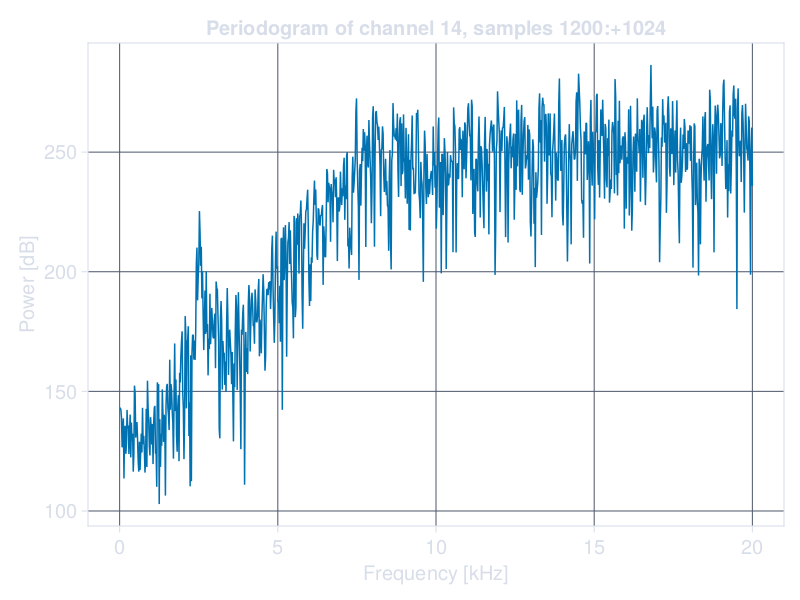

In [5]:
F = Figure(backgroundcolor=:transparent)
Axis(
    F[1,1], 
    title="Periodogram of channel 14, samples 1200:+1024",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
lines!(Ω[Ω .>= 0]./1000, amp2db.(Pₓₓ[Ω .>= 0]))
save("1a.pdf", F)
F

In [6]:
window_func = kaiser(N,2.5);

U = sum(abs.(window_func).^2)/N
Pₓₓ2 = PSD(arr.*window_func)./(U*N);

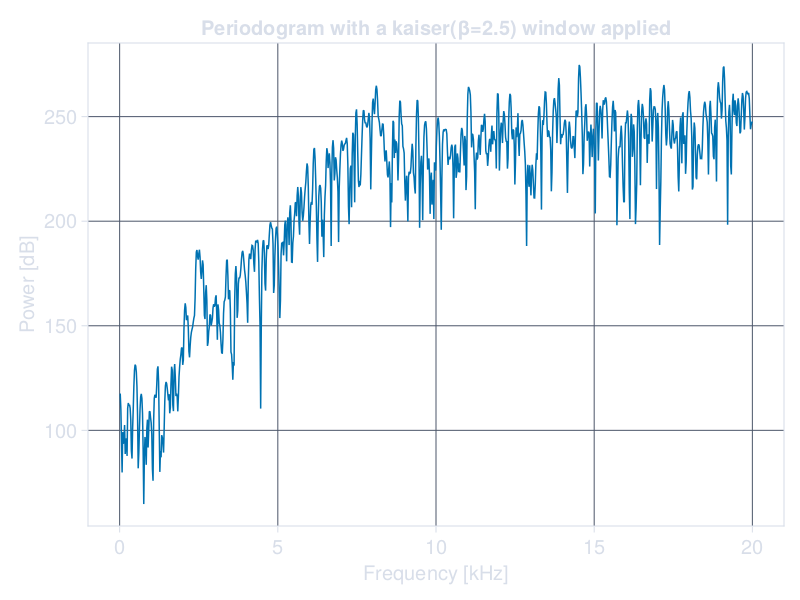

In [7]:
F = Figure(backgroundcolor=:transparent)
Axis(
    F[1,1], 
    title="Periodogram with a kaiser(β=2.5) window applied",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
Ω2 = range(-fs/2,fs/2,2N-1)
lines!(Ω2[Ω2 .>= 0]./1000, amp2db.(Pₓₓ2[Ω2 .>= 0]))
save("1b.pdf", F)
F

In [8]:
function welch(x, L=256, O = 0.5)
    N = length(x)
    D = Int(floor(L*O)) # Index Overlap 
    K = (N-L)÷D+1       # Number of slices
    slices = [ a:a+L-1 for a=1:D:K*D ]
    return mapreduce(permutedims, vcat, [x[slice] for slice=slices])
end


welch (generic function with 3 methods)

In [52]:
welch_arr = welch(arr)
K, L = size(welch_arr)
Uw = sum(abs.(window_func).^2)/N
window_func = kaiser(L, 2.5)
Pₓₓw = 1/(Uw*L) * mapslices(
    PSD ∘ (x->x.*window_func), 
    welch_arr, 
    dims=2
)

Ωw = range(-fs/2,fs/2,2L-1)
Pₓₓw = mean(Pₓₓw, dims=1)

1×511 Matrix{Float64}:
 1.8889e12  1.92656e12  3.90679e12  …  6.72881e12  3.90679e12  1.92656e12

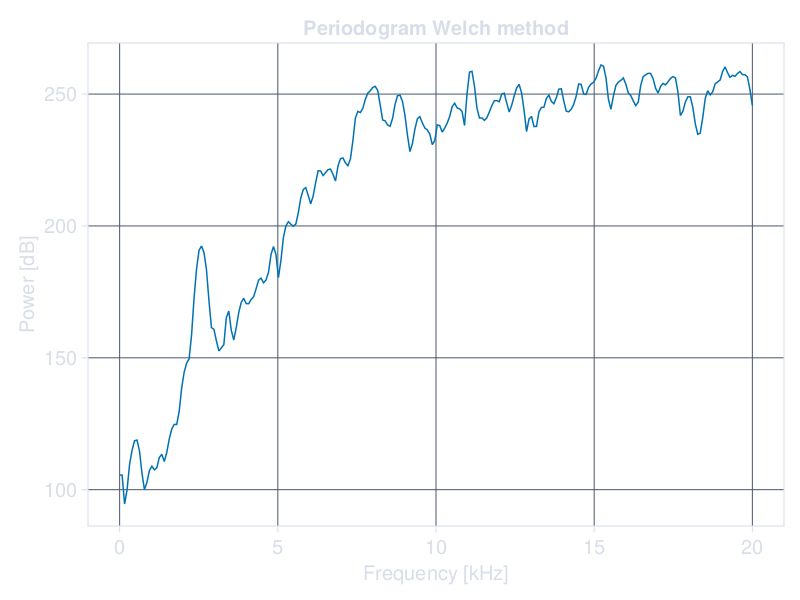

In [53]:
F = Figure(backgroundcolor=:transparent)
Axis(
    F[1,1], 
    title="Periodogram Welch method",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
lines!(Ωw[Ωw .>= 0]./1000, amp2db.(Pₓₓw[Ωw .>= 0]))
save("1c.pdf", F)
F

In [32]:
# Multi taper
nw = 2
tapers = dpss(N, nw)
N,K = size(tapers)
Umt = sum(abs.(tapers).^2, dims=1)/N
Sxxs = mapslices(PSD, arr.*tapers, dims=1)./(Umt*K)
Pₓₓmt = mean(Sxxs, dims=2);

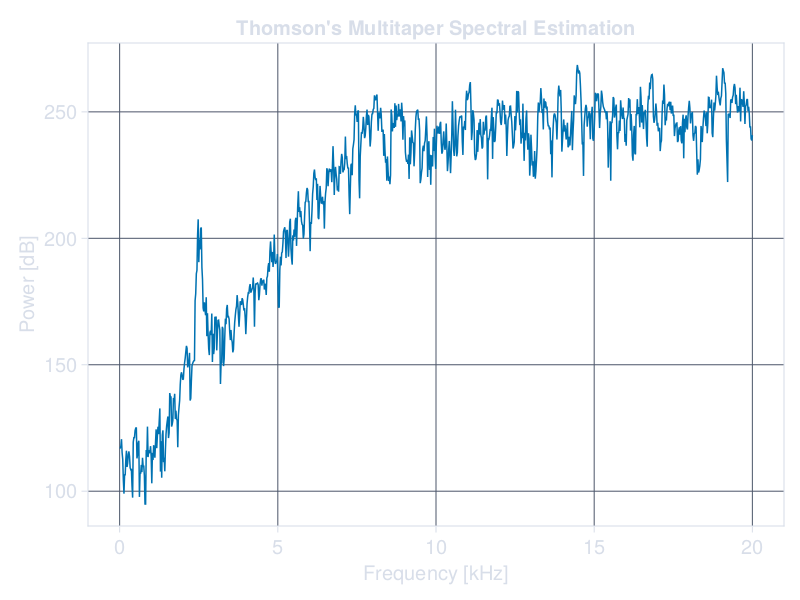

In [51]:
Ω = range(-fs/2,fs/2,2N-1)
F = Figure(backgroundcolor=:transparent)
Axis(
    F[1,1], 
    title="Thomson's Multitaper Spectral Estimation",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
Ωmt = range(-fs/2,fs/2,2N-1)
lines!(Ωmt[Ωmt .>= 0]./1000, amp2db.(Pₓₓmt[Ωmt .>= 0]))
save("1d.pdf", F)
F

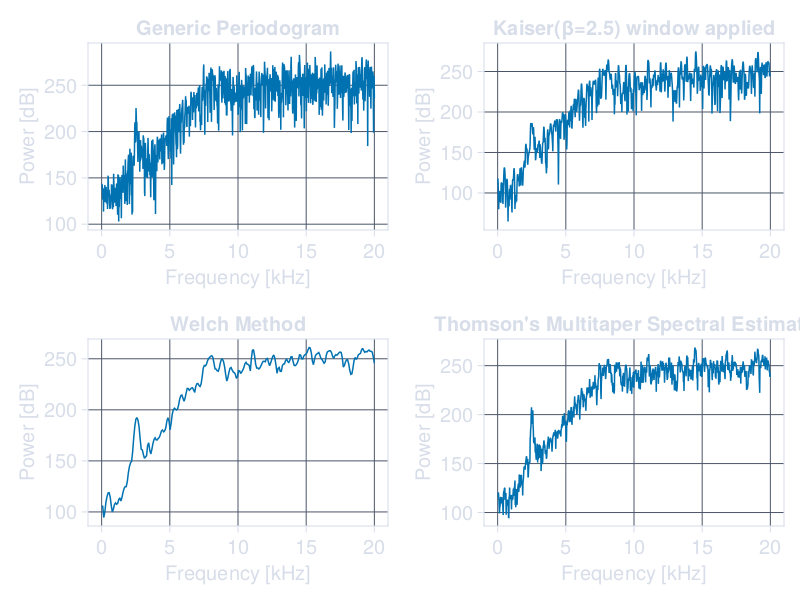

In [50]:
F = Figure(backgroundcolor=:transparent)
Axis(
    F[1,1], 
    title="Generic Periodogram",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
lines!(Ω[Ω .>= 0]./1000, amp2db.(Pₓₓ[Ω .>= 0]))
Axis(
    F[1,2], 
    title="Kaiser(β=2.5) window applied",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
lines!(Ω2[Ω2 .>= 0]./1000, amp2db.(Pₓₓ2[Ω2 .>= 0]))
Axis(
    F[2,1], 
    title="Welch Method",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
lines!(Ωw[Ωw .>= 0]./1000, amp2db.(Pₓₓw[Ωw .>= 0]))
Axis(
    F[2,2], 
    title="Thomson's Multitaper Spectral Estimation",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
Ωmt = range(-fs/2,fs/2,2N-1)
lines!(Ωmt[Ωmt .>= 0]./1000, amp2db.(Pₓₓmt[Ωmt .>= 0]))
save("1e.pdf", F)
F

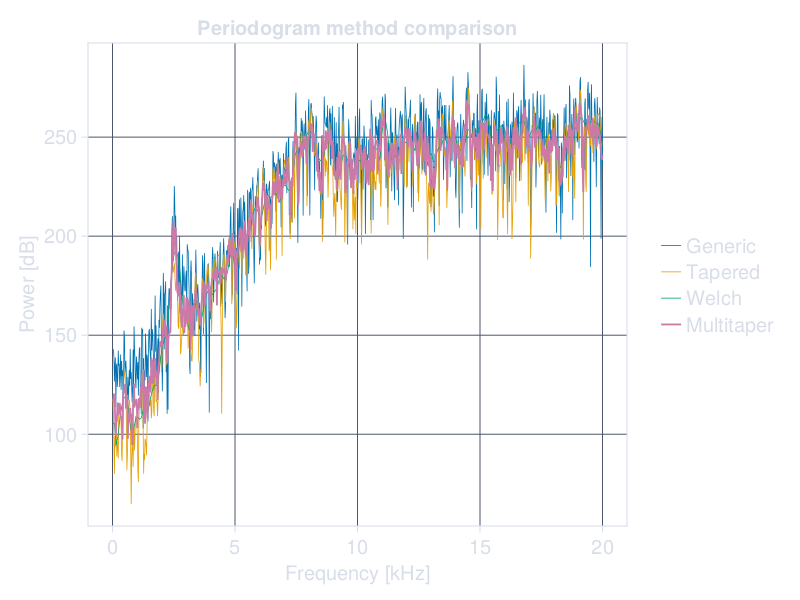

In [54]:
F = Figure(backgroundcolor=:transparent)
Axis(
    F[1,1], 
    title="Periodogram method comparison",
    xlabel="Frequency [kHz]",
    ylabel="Power [dB]"
)
l1 = lines!(Ω[Ω .>= 0]./1000, amp2db.(Pₓₓ[Ω .>= 0]), linewidth=0.8)
l2 = lines!(Ω2[Ω2 .>= 0]./1000, amp2db.(Pₓₓ2[Ω2 .>= 0]), linewidth=0.8)
l3 = lines!(Ωw[Ωw .>= 0]./1000, amp2db.(Pₓₓw[Ωw .>= 0]), linewidth=1.8)
l4 = lines!(Ωmt[Ωmt .>= 0]./1000, amp2db.(Pₓₓmt[Ωmt .>= 0]), linewidth=0.8)
leg = Legend(F[1,2], [l1, l2, l3, l4], ["Generic", "Tapered", "Welch", "Multitaper"])
save("1f.pdf",F)
F